In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

2023-05-21 01:31:47.104297: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-21 01:31:53.055631: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-05-21 01:31:53.056831: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

In [3]:
dataPath = 'BMI/Data/'

# load csv

In [4]:
data = pd.read_csv(dataPath+'data.csv',index_col=0)

In [5]:
imgNamesInDir = pd.Series(os.listdir(dataPath+'Images/'),name='name').sort_values()
imgNamesInDir = imgNamesInDir.to_frame()
imgNamesInDir['exists'] = 1

In [6]:
merged = data.merge(imgNamesInDir,on='name')

In [7]:
labels = merged[merged.exists==1]

In [35]:
tst_img = tf.keras.utils.load_img(
    dataPath+f"Images/img_0.bmp",
    color_mode='rgb',
)

In [25]:
import matplotlib.pyplot as plt

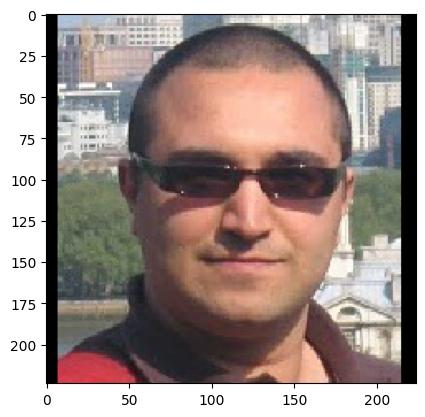

In [40]:
plt.imshow(np.array(tf.image.resize_with_pad(
    tst_img,
    224,
    224,
    method='nearest'
)))

# Load img

In [9]:
data

,bmi,gender,is_training,name
0,34.207396,Male,1,img_0.bmp
1,26.453720,Male,1,img_1.bmp
2,34.967561,Female,1,img_2.bmp
3,22.044766,Female,1,img_3.bmp
4,37.758789,Female,1,img_4.bmp
...,...,...,...,...
4201,34.078947,Male,0,img_4201.bmp
4202,34.564776,Female,0,img_4202.bmp
4203,27.432362,Female,0,img_4203.bmp
4204,40.492800,Male,0,img_4204.bmp


In [8]:
trainLabels = labels[labels.is_training==1]
testLabels = labels[labels.is_training==0]

In [9]:
def toDataset(labels):
    out_imgs = np.zeros((labels.shape[0],224,224,3))
    for i in range(labels.shape[0]):
        img_name = labels['name'].iloc[i]  
        img = tf.keras.utils.load_img(
            dataPath+f"Images/{img_name}",
            color_mode='rgb',
        )
        out_imgs[i] = np.array(
            tf.image.resize_with_pad(
                img,
                224,
                224,
                method='nearest'
            )
        )
    return out_imgs

In [236]:
train_imgs = toDataset(trainLabels)

In [51]:
batches=[]
for i in range(0,trainLabels.shape[0],321):
    batches.append(train_imgs[i:i+321])

# Load vgg

In [11]:
import keras_vggface

In [12]:
from keras_vggface.vggface import VGGFace

In [13]:
vggFeatures = VGGFace(
    model='resnet50', include_top=False, 
    input_shape=(224, 224, 3), 
    pooling='avg')

2023-05-20 04:14:09.595038: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-05-20 04:14:09.595081: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-20 04:14:09.595108: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tensorflow-2-11-20230515-133657): /proc/driver/nvidia/version does not exist
2023-05-20 04:14:09.596594: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild Tens

In [69]:
for i in range(len(batches)):
    np.savetxt(
        dataPath+f'img_batch{i}.csv', 
        vggFeatures.predict(batches[i]),
        delimiter=","
    )

11/11 [==============================] - 21s 2s/step


# test set

In [82]:
test_imgs = toDataset(testLabels)

In [87]:
batches=[]
for i in range(0,testLabels.shape[0],376):
    batches.append(test_imgs[i:i+376])

In [88]:
for i in range(len(batches)):
    np.savetxt(
        dataPath+f'test_img_batch{i}.csv', 
        vggFeatures.predict(batches[i]),
        delimiter=","
    )

12/12 [==============================] - 27s 2s/step


# concat to single frame

In [9]:
img_feats_batches = []
for i in range(10):
    img_feats_batches.append(
        pd.read_csv(dataPath+f'img_batch{i}.csv',header=None)
    )

img_feats = pd.concat(img_feats_batches).reset_index(drop=True)
# img_feats.columns = [f'img_feat{i}' for i in range(img_feats.shape[1])]
# img_feats = img_feats.reset_index(drop=True) 
# img_feats['isFemale'] = trainLabels.gender.apply(lambda x: x=='Female').reset_index(drop=True)

In [10]:
img_feats_batches = []
for i in range(2):
    img_feats_batches.append(
        pd.read_csv(dataPath+f'test_img_batch{i}.csv',header=None)
    )

test_img_feats = pd.concat(img_feats_batches)
test_img_feats.columns = [f'img_feat{i}' for i in range(test_img_feats.shape[1])]
# test_img_feats = test_img_feats.reset_index(drop=True) 
# test_img_feats['isFemale'] = testLabels.gender.apply(lambda x: x=='Female').reset_index(drop=True)

# add kmeans

In [39]:
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder

In [107]:
img_feats.describe().loc[['min','mean','max']].T.describe()

,min,mean,max
count,2048.0,2048.000000,2048.000000
mean,0.0,0.978536,14.346108
std,0.0,0.611856,4.021932
min,0.0,0.027314,2.703839
25%,0.0,0.573416,11.596438
50%,0.0,0.842875,13.993691
75%,0.0,1.203490,16.494279
max,0.0,6.680640,33.060680


In [152]:
std = StandardScaler()
scaled_data = std.fit_transform(np.log(test_img_feats+1))

In [153]:
kmeans = []
for i in range(3,35):
    km = KMeans(n_clusters=i,random_state=1337)
    km.fit_predict(scaled_data)
    kmeans.append((i,km.inertia_))
    print(i)

3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34


In [154]:
resFrame = pd.DataFrame(kmeans)
resFrame.columns = ['i','idx']

<AxesSubplot:xlabel='i', ylabel='idx'>

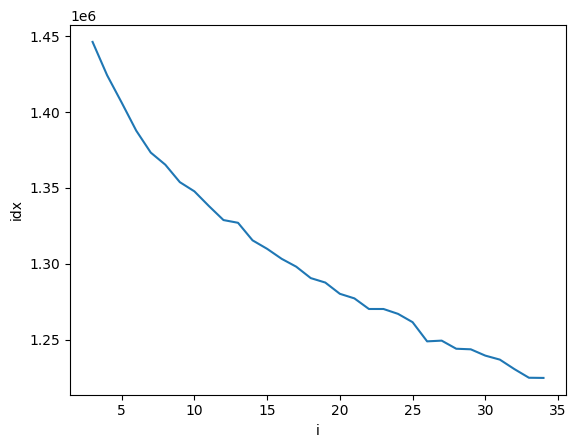

In [155]:
sns.lineplot(data=resFrame,x='i',y='idx')

In [193]:
km = KMeans(n_clusters=26,random_state=1337)
cluster_labels = km.fit_predict(np.log(img_feats+1))

In [194]:
ohe = OneHotEncoder(sparse=False)
ohe_clusters = ohe.fit_transform(cluster_labels.reshape(-1,1))

In [195]:
trainKm = np.hstack([np.log(img_feats+1),ohe_clusters])

In [196]:
testKm = np.hstack([
    np.log(test_img_feats+1),
    ohe.transform(
        km.predict(
            std.transform(np.log(test_img_feats+1))
        ).reshape(-1,1)
    )
])

# Linear regression

In [56]:
from sklearn.linear_model import RidgeCV

In [315]:
linReg = RidgeCV(
    [6000],
    cv=5,
    scoring='neg_mean_squared_error'
)

In [316]:
linReg.fit(np.log(img_feats+0.1),trainLabels['bmi'])

RidgeCV(alphas=array([6000]), cv=5, scoring='neg_mean_squared_error')

In [310]:
linReg.alpha_

8000

In [255]:
regTopFeats = pd.Series(
    linReg.coef_.flatten()
)

In [256]:
topFeats = regTopFeats.apply(abs).sort_values(ascending=False).head(20).index

Text(0.5, 1.0, '2048')

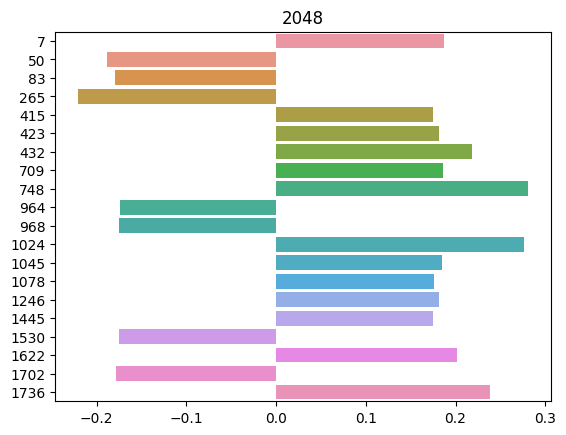

In [257]:
ax= sns.barplot(
    y=topFeats,
    x=regTopFeats.loc[topFeats],
    orient='h'
)
ax.set_title(img_feats.shape[1])

# Evaluation

In [234]:
from sklearn.metrics import mean_squared_error

In [288]:
# training set
mean_squared_error(linReg.predict(np.log(img_feats+0.1)),trainLabels['bmi'])

25.291343552760424

In [322]:
# testing set
mean_squared_error(linReg.predict(np.log(test_img_feats+0.1)),testLabels['bmi'])

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RidgeCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


51.7848626173787

In [340]:
tst_results = pd.DataFrame(np.vstack([linReg.predict(np.log(test_img_feats+0.1)),testLabels['bmi'].to_numpy()]).T)
tst_results.columns = ['pred','true']
tst_results.corr()

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RidgeCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


,pred,true
pred,1.000000,0.633623
true,0.633623,1.000000


In [298]:
tst_results = pd.DataFrame(np.vstack([linReg.predict(np.log(test_img_feats+0.1)),testLabels['bmi'].to_numpy()]).T)
tst_results.columns = ['pred','true']
tst_results.corr()

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RidgeCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


,pred,true
pred,1.000000,0.633623
true,0.633623,1.000000


In [ ]:
tst_results = pd.DataFrame(
    np.vstack([
        linReg.predict(np.log(tst_img_feats[dropIdx.gender=='Male']+0.1)),
        male['bmi'].to_numpy()
    ]).T)
tst_results.columns = ['pred','true']
tst_results.corr()

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RidgeCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


,pred,true
pred,1.000000,0.636512
true,0.636512,1.000000


In [342]:
tst_results = pd.DataFrame(
    np.vstack([
        linReg.predict(np.log(tst_img_feats[dropIdx.gender=='Feale']+0.1)),
        female['bmi'].to_numpy()
    ]).T)
tst_results.columns = ['pred','true']
tst_results.corr()

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RidgeCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


,pred,true
pred,1.000000,0.639936
true,0.639936,1.000000


In [ ]:
np.log(tst_img_feats[dropIdx.gender=='Male']+0.1)

0

In [339]:
mean_squared_error(linReg.predict(np.log(tst_img_feats[dropIdx.gender=='Male']+0.1)),male['bmi'])

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RidgeCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


47.97879720448173

In [336]:
mean_squared_error(linReg.predict(np.log(tst_img_feats[dropIdx.gender=='Female']+0.1)),female['bmi'])

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RidgeCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


55.2158542423392

### old eval

In [298]:
# trivial predictor
mean_squared_error(testLabels['bmi'],[testLabels['bmi'].mean()]*testLabels.shape[0])

84.89282747444129

In [ ]:
# training set
mean_squared_error(linReg.predict(np.log(img_feats+1)),trainLabels['bmi'])

29.08976593767466

In [321]:
# testing set
mean_squared_error(linReg.predict(np.log(test_img_feats+1)),testLabels['bmi'])

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RidgeCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


222.3345635315218

In [47]:
# training set
mean_squared_error(linReg.predict(img_feats),trainLabels['bmi'])

31.60635916243325

In [22]:
# testing set
mean_squared_error(linReg.predict(test_img_feats),testLabels['bmi'])

53.55544574541435

In [23]:
tst_results = pd.DataFrame(np.vstack([linReg.predict(test_img_feats),testLabels['bmi'].to_numpy()]).T)
tst_results.columns = ['pred','true']

In [24]:
tst_results.corr()

,pred,true
pred,1.000000,0.620201
true,0.620201,1.000000


In [204]:
import seaborn as sns

<AxesSubplot:xlabel='true', ylabel='pred'>

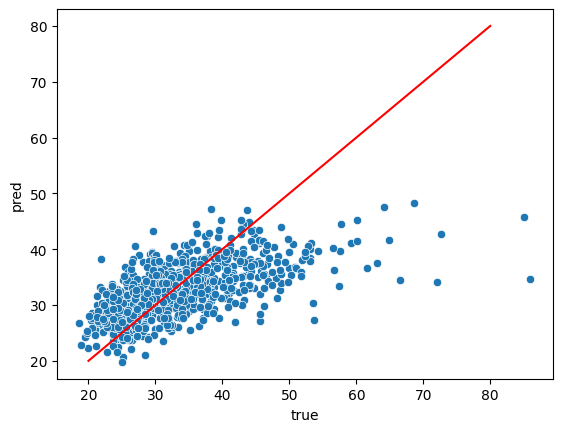

In [205]:
sns.scatterplot(data=tst_results,x='true',y='pred')
sns.lineplot(x=[20,80],y=[20,80],color='red')

In [240]:
import pickle

In [320]:
# pickle.dump(linReg, open('ridgeReg.pkl', 'wb'))

In [15]:
loaded = pickle.load(open('ridgeReg.pkl', 'rb'))

In [16]:
# training set
mean_squared_error(loaded.predict(img_feats),trainLabels['bmi'])

31.60635916243325

In [323]:
dropIdx = testLabels.reset_index(drop=True)
male = dropIdx[dropIdx.gender=='Male']
female = dropIdx[dropIdx.gender=='Female']

In [324]:
tst_img_feats = test_img_feats.reset_index(drop=True)

In [35]:
mean_squared_error(loaded.predict(tst_img_feats[dropIdx.gender=='Male']),male['bmi'])

50.27757375057675

In [36]:
mean_squared_error(loaded.predict(tst_img_feats[dropIdx.gender=='Female']),female['bmi'])

57.86206525863177

In [37]:
# trivial predictor
mean_squared_error(female['bmi'],[female['bmi'].mean()]*female.shape[0])

90.10077974002834

In [38]:
# trivial predictor
mean_squared_error(male['bmi'],[male['bmi'].mean()]*male.shape[0])

80.5111111583478

# Extract faces

In [ ]:
import mtcnn

In [40]:
multi_tst_img_raw = tf.keras.utils.load_img(
    dataPath+f"multiface.jpg",
    color_mode='rgb',
)

In [41]:
detector = mtcnn.MTCNN()
# detect faces in the image
results = detector.detect_faces(np.array(multi_tst_img_raw))

1/1 [==============================] - 0s 143ms/step


In [63]:
def extractFaces(results,origImg):
    outLs = []
    for res in results:
        x1,y1,width,height = res['box']
        xDelta = int(width*0.15)
        yDelta = int(height*0.2)
        x1 = max(1,x1-xDelta)
        y1 = max(1,y1-yDelta)
        
        width = min(origImg.shape[1],width+2*xDelta)
        height = min(origImg.shape[0],height+2*yDelta)

        outLs.append(
            np.expand_dims(np.array(
                tf.image.resize_with_pad(
                    origImg[
                        y1:y1+height,
                        x1:x1+width,
                        :
                    ],
                    224,224,method='nearest'
                )
            ),axis=0)
        )
    return outLs

In [64]:
tstLs = extractFaces(results,np.array(multi_tst_img_raw))

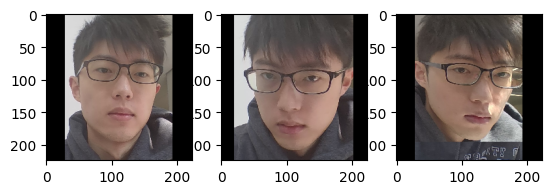

In [61]:
fig,ax = plt.subplots(1,3)
ax[0].imshow(tstLs[0])
ax[1].imshow(tstLs[1])
ax[2].imshow(tstLs[2])

In [68]:
ridgeReg = pickle.load(open('ridgeReg.pkl', 'rb'))

In [78]:
np.vstack(tstLs)

(3, 224, 224, 3)

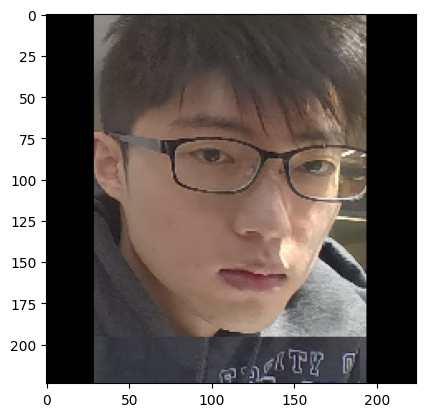

In [80]:
for eh in np.vstack(tstLs):
    plt.imshow(eh)

In [81]:
faceFeat = vggFeatures.predict(np.vstack(tstLs))

1/1 [==============================] - 0s 241ms/step


In [82]:
faceFeat.shape

(3, 2048)

In [85]:
preds = ridgeReg.predict(faceFeat)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RidgeCV was fitted with feature names
  "X does not have valid feature names, but"


In [89]:
round(preds[0],2)

24.82